#Libraries

In [ ]:
import random
import time
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tempfile
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle

from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential, save_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/drive/MyDrive/Fish Project/Dataset'
path_train = os.path.join(base_dir, 'train')
path_val = os.path.join(base_dir, 'val')
os.mkdir(path_train)
os.mkdir(path_val)

In [ ]:
label = ['Segar', 'Tidak Segar']

In [ ]:
for name in label:
  new_folder_train = os.path.join(path_train,str(name))
  new_folder_val = os.path.join(path_val,str(name))
  os.mkdir(new_folder_train)
  os.mkdir(new_folder_val)

In [ ]:
for name in label:
  train, val = train_test_split(os.listdir(os.path.join(base_dir,name)), test_size = 0.3)

  for i in train:
    shutil.copy(os.path.join(base_dir,name,i), os.path.join(path_train,name,i))
  for i in val:
    shutil.copy(os.path.join(base_dir,name,i), os.path.join(path_val,name,i))

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size =(150,150),
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    path_val,
    target_size = (150,150),
    class_mode = 'binary'
)

Found 28 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [ ]:
mobnet = tf.keras.applications.MobileNet(input_shape=(150,150,3),
                                        include_top=False, 
                                         weights='imagenet')
mobnet.trainable=False

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model2 = tf.keras.Sequential([
  mobnet,
  tf.keras.layers.Conv2D(1024, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_wo_ft.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 1024)        9438208   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 12,668,097
Trainable params: 9,439,233
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history1 = model2.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=20, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator),callbacks=[checkpointer,earlystop])

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 1.0822 - accuracy: 0.3571 - val_loss: 0.4968 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.49676, saving model to mobnet_wo_ft.hdf5
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.7789 - accuracy: 0.5357 - val_loss: 0.4874 - val_accuracy: 0.8333

Epoch 00002: val_loss improved from 0.49676 to 0.48737, saving model to mobnet_wo_ft.hdf5
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.5520 - accuracy: 0.6429 - val_loss: 0.4483 - val_accuracy: 0.8333

Epoch 00003: val_loss improved from 0.48737 to 0.44831, saving model to mobnet_wo_ft.hdf5
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.3435 - accuracy: 0.9643 - val_loss: 0.2539 - val_accuracy: 0.9167

Epoch 00004: val_loss improved from 0.44831 to 0.25390, saving model to mobnet_wo_ft.hdf5
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.2852 - accuracy: 0.96

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

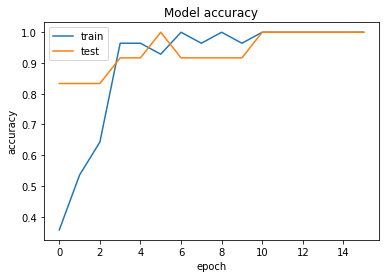

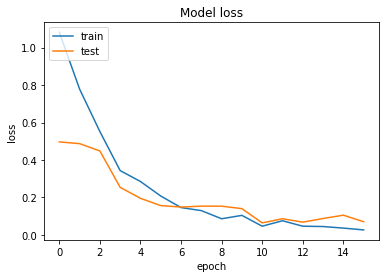

In [ ]:
plot_train_history(history1)

In [ ]:
model=tf.keras.models.load_model("./mobnet_wo_ft.hdf5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmps5vog6bx/assets


INFO:tensorflow:Assets written to: /tmp/tmps5vog6bx/assets


50562676

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model2.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Tidak Segar")
  else:
    print(fn + " Segar")
 

Saving Segar.jpg to Segar.jpg
Saving tidak segar.jpg to tidak segar.jpg
[0.3319742]
Segar.jpg Segar
[0.62196124]
tidak segar.jpg Tidak Segar


In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 3.0 MB/s 


In [ ]:
!tensorflowjs_converter \
     --input_format=keras \
     mobnet_wo_ft.hdf5 \
     model_js

In [ ]:
!zip -r /content/model.zip /content/model_js

  adding: content/model_js/ (stored 0%)
  adding: content/model_js/group1-shard9of13.bin (deflated 8%)
  adding: content/model_js/group1-shard2of13.bin (deflated 8%)
  adding: content/model_js/group1-shard1of13.bin (deflated 8%)
  adding: content/model_js/group1-shard5of13.bin (deflated 8%)
  adding: content/model_js/group1-shard8of13.bin (deflated 8%)
  adding: content/model_js/group1-shard13of13.bin (deflated 7%)
  adding: content/model_js/group1-shard12of13.bin (deflated 7%)
  adding: content/model_js/group1-shard7of13.bin (deflated 8%)
  adding: content/model_js/model.json (deflated 94%)
  adding: content/model_js/group1-shard4of13.bin (deflated 8%)
  adding: content/model_js/group1-shard6of13.bin (deflated 8%)
  adding: content/model_js/group1-shard3of13.bin (deflated 8%)
  adding: content/model_js/group1-shard10of13.bin (deflated 7%)
  adding: content/model_js/group1-shard11of13.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

deployed model can be checked [here](https://bagussatya.github.io/)